In [47]:
import pandas as pd
import numpy as np
import json
import zipfile
import os
import time

from sklearn import preprocessing
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [48]:
embedding_data = pd.read_csv('./content/vecs_bbc.tsv', sep='\t',header=None)
embedding_labels = pd.read_csv('./content/meta_bbc.tsv',sep='\t',header=None)
embedding_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.077694,0.245382,-0.262754,-0.623115,0.261624,0.271294,0.264885,-0.010171,-0.212426,0.032702,-0.212508,-0.000707,0.041491,-0.394709,-0.075083,0.105326
1,0.028982,-0.002739,-0.172792,-0.402453,0.091850,0.181848,0.122647,0.079560,-0.166386,0.078393,-0.254011,-0.135489,-0.034102,-0.322451,-0.153217,-0.241937
2,-0.134570,-0.135690,-0.245342,-0.684106,-0.164621,0.168613,0.188155,0.202027,-0.299157,0.310751,-0.461403,-0.126672,0.325253,0.139450,-0.254225,-0.323384
3,0.068602,0.263519,-0.124324,-0.443559,0.206263,0.297280,0.127670,-0.010272,-0.132489,-0.133799,0.072337,0.091870,-0.181317,-0.345912,0.017051,0.357135
4,0.098259,-0.216865,-0.529588,-0.198344,-0.105798,0.402794,0.409604,0.289512,-0.215429,-0.194881,0.099063,-0.313497,0.015787,0.000599,-0.102476,-0.045758


In [49]:
print(embedding_data.shape)
print(embedding_labels.shape)

(999, 16)
(999, 1)


In [50]:
embedding_data.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
count,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000
mean,-0.042605,0.060662,-0.091352,-0.162579,0.034999,0.043643,0.037598,0.012151,-0.099776,0.042478,-0.053570,0.010816,0.003579,-0.121093,-0.063997,0.065827
std,0.328608,0.340188,0.334591,0.338366,0.290253,0.305077,0.316315,0.315884,0.324112,0.316566,0.323739,0.349208,0.303377,0.318180,0.322333,0.361570
min,-0.902797,-0.900896,-0.950015,-0.970679,-0.848909,-0.731398,-0.846035,-0.991919,-0.835024,-0.821064,-0.862397,-0.966123,-0.749895,-1.140169,-0.859375,-0.954107
25%,-0.276231,-0.168674,-0.344598,-0.425789,-0.156517,-0.179653,-0.187342,-0.202914,-0.320787,-0.191353,-0.292071,-0.220086,-0.210305,-0.336303,-0.288685,-0.171786
50%,-0.053109,0.060896,-0.095307,-0.193410,0.031065,0.064091,0.031321,0.029714,-0.130620,0.037828,-0.049701,0.035752,0.000810,-0.119410,-0.082555,0.063527
75%,0.179434,0.274385,0.153853,0.068411,0.217978,0.278271,0.259252,0.235751,0.101161,0.275860,0.180170,0.248030,0.194594,0.087362,0.145925,0.322955
max,0.800541,1.103898,0.894876,0.807736,0.943576,0.798331,0.925828,0.815204,0.878758,0.936311,0.851330,0.996300,0.883168,0.904354,0.917513,1.040819


#### Scale the variables

Since some of the features have very high variablity, they are being scaled such that each of them has uniform variablity.

In [51]:
x_input = preprocessing.scale(embedding_data.iloc[:,:].to_numpy())

In [52]:
np.around(np.mean(x_input, axis=0))

array([-0.,  0., -0., -0.,  0., -0., -0., -0., -0.,  0.,  0., -0.,  0.,
       -0.,  0.,  0.])

In [53]:
np.std(x_input, axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [54]:
x_input.shape

(999, 16)

#### Proportion of variance

Figure out how many components are needed to explain the variance

In [55]:
pca = PCA().fit(x_input)

In [56]:
pca.explained_variance_ratio_

array([0.37454846, 0.33273579, 0.24442388, 0.02053271, 0.00818002,
       0.0053444 , 0.00303199, 0.00234983, 0.002245  , 0.00144713,
       0.00133425, 0.00104259, 0.00091499, 0.00075596, 0.00059173,
       0.00052127])

In [57]:
### convert into dataframe
pca_variance = pd.DataFrame(pca.explained_variance_ratio_)
pca_variance.rename(columns = {0:"var_ratio"},inplace=True)
pca_variance["cum_var_ratio"] = pca_variance.cumsum()
pca_variance["pca_comp"] = ""
for i in range(pca_variance.shape[0]):
    pca_variance.loc[i, "pca_comp"] = "pca_" + str(i+1)
pca_variance = pca_variance[["pca_comp","var_ratio","cum_var_ratio"]]
pca_variance

,pca_comp,var_ratio,cum_var_ratio
0,pca_1,0.374548,0.374548
1,pca_2,0.332736,0.707284
2,pca_3,0.244424,0.951708
3,pca_4,0.020533,0.972241
4,pca_5,0.008180,0.980421
5,pca_6,0.005344,0.985765
6,pca_7,0.003032,0.988797
7,pca_8,0.002350,0.991147
8,pca_9,0.002245,0.993392
9,pca_10,0.001447,0.994839


In [58]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=2,column_titles=["Variance by PCA Component", "Cumulative variance by PCA components"])

fig.add_trace(
    go.Scatter(x=pca_variance["pca_comp"], 
               y=pca_variance["var_ratio"],
               hovertemplate ='<i>Component</i>: %{x}'+'<br><b>Variance</b>: %{y:.2f}<br>'),
    row=1, col=1,
    
)

fig.add_trace(
    go.Scatter(x=pca_variance["pca_comp"], 
               y=pca_variance["cum_var_ratio"],
               hovertemplate ='<i>Component</i>: %{x}'+'<br><b>Cumilative variance</b>: %{y:.2f}<br>'),
                row=1, col=2
    )



fig.update_layout(height=400, width=1000, title_text="Proportion of variance by PCA components",showlegend = False)
fig.show()

The first component explains 47% of the variance in data. After the first component, it becomes flat across other components.

### Calculate the PCA components

In [59]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(x_input)

#### Figure out the weights for each of the feature 

In [60]:
pca.components_

array([[ 0.27113455,  0.29641578,  0.1629283 ,  0.05084815,  0.40108067,
        -0.30048918,  0.05366309, -0.38734908,  0.31553397,  0.09530055,
        -0.0320072 ,  0.15397869,  0.04238804, -0.33076591,  0.32912667,
         0.22914864],
       [ 0.25398847, -0.28129316, -0.25301124,  0.03977676, -0.01770177,
        -0.06690782,  0.39399232, -0.07035902,  0.20027864,  0.23945927,
        -0.2646961 , -0.36949845,  0.38504895,  0.16100157,  0.20209104,
        -0.32669007]])

In [61]:
feature_weights = pd.DataFrame(pca.components_)
feature_weights.columns = embedding_data.iloc[:,:].columns
for i in range(feature_weights.shape[0]):
    feature_weights.loc[i, "pca_comp"] = "pca_" + str(i+1)
feature_weights.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,pca_comp
0,0.271135,0.296416,0.162928,0.050848,0.401081,-0.300489,0.053663,-0.387349,0.315534,0.095301,-0.032007,0.153979,0.042388,-0.330766,0.329127,0.229149,pca_1
1,0.253988,-0.281293,-0.253011,0.039777,-0.017702,-0.066908,0.393992,-0.070359,0.200279,0.239459,-0.264696,-0.369498,0.385049,0.161002,0.202091,-0.326690,pca_2


In [62]:
pca_components = pd.DataFrame(pca_result)
pca_components.rename(columns={0:"pca_1",1:"pca_2"},inplace=True)
pca_components.head()

,pca_1,pca_2
0,0.464104,0.172292
1,-0.378691,0.575695
2,-1.807906,1.608386
3,0.653802,-0.942323
4,-1.747493,1.118617


### Merge PCA component information with state data

In [63]:
embedding_labels = pd.concat([embedding_labels, pca_components], axis=1)
embedding_labels.rename(columns={0:"word"},inplace=True)
embedding_labels.head()

,word,pca_1,pca_2
0,<OOV>,0.464104,0.172292
1,s,-0.378691,0.575695
2,said,-1.807906,1.608386
3,will,0.653802,-0.942323
4,not,-1.747493,1.118617


In [64]:
import plotly.express as px

fig = px.scatter(embedding_labels, x="pca_1", y="pca_2", hover_name="word",size_max=60)

fig.update_traces(textposition='top center')

fig.show()

### Conclusion with PCA

Looking at the mouse over, it can be seen that the bad review words are on the right side(e.g. worst, waste, uinteresting, dissappointment etc.)

Good review words (e.g. refreshing, superb, excellent etc.) are on the left side.

### t-SNE transofmration and visulization

In [65]:
x_input = embedding_data.iloc[:,:].to_numpy()
#x_input = usarrest_data.iloc[:,1:5].to_numpy()
x_input.shape

(999, 16)

In [66]:
### Do TSNE transformation
time_start = time.time()
X_embedded = TSNE(n_components=2).fit_transform(x_input)
print(X_embedded.shape)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

(999, 2)
t-SNE done! Time elapsed: 6.012790203094482 seconds


In [67]:
tsne_output = pd.DataFrame(X_embedded)
tsne_output.rename(columns = {0:"tsne_1",1:"tsne_2"},inplace = True)
tsne_output.head()

,tsne_1,tsne_2
0,3.110672,0.186159
1,0.512373,2.412939
2,-14.880473,16.986753
3,8.647102,-7.433567
4,-14.663816,1.165056


In [68]:
embedding_labels = pd.concat([embedding_labels, tsne_output], axis=1)
embedding_labels.head()

,word,pca_1,pca_2,tsne_1,tsne_2
0,<OOV>,0.464104,0.172292,3.110672,0.186159
1,s,-0.378691,0.575695,0.512373,2.412939
2,said,-1.807906,1.608386,-14.880473,16.986753
3,will,0.653802,-0.942323,8.647102,-7.433567
4,not,-1.747493,1.118617,-14.663816,1.165056


In [69]:
import plotly.express as px

fig = px.scatter(embedding_labels, x="tsne_1", y="tsne_2", size_max=60,
                 hover_name="word", hover_data=["pca_1", "pca_2"])

fig.update_traces(textposition='top center')

fig.update_layout(
    hoverlabel=dict(
        bgcolor="white", 
        font_size=16, 
        font_family="Rockwell"
    )
)


fig.show()

#### Implementing K Nearest Neighbor

#### First figure out the right number of clusters

In [70]:
# calculate distortion for a range of number of cluster
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(x_input)
    distortions.append(km.inertia_)

In [71]:
fig = make_subplots(rows=1, cols=1,column_titles=["Variance by PCA Component", "Cumulative variance by PCA components"])

fig.add_trace(
    go.Scatter(x=list(range(1,11)), 
               y=distortions,
               hovertemplate ='<i>K</i>: %{x}'+'<br><b>Distortion</b>: %{y:.2f}<br>'),
    row=1, col=1,
    
)


fig.update_layout(height=400, width=1000, title_text="Proportion of variance by PCA components",showlegend = False)
fig.show()

Since distortion flattens after 4 clusters, may be a good idea to go with 3 clusters for now.

In [81]:
### Run 
kmeans = KMeans(n_clusters=5, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0)
kmeans.fit(x_input)
y_kmeans = kmeans.predict(x_input)

In [82]:
kmeans.cluster_centers_

array([[-0.19770072, -0.29972602, -0.26561392, -0.33636198, -0.28860881,
         0.23683365,  0.18376731,  0.29354077, -0.32036984,  0.11679307,
        -0.18537418, -0.24672341,  0.19228874,  0.29055759, -0.27537955,
        -0.31654434],
       [-0.08984611,  0.0355085 , -0.27338238,  0.17155198, -0.06470898,
         0.33924868, -0.07671896,  0.23355221, -0.13992654, -0.33784561,
         0.31691939,  0.00535848, -0.30925319, -0.24588716, -0.14501589,
         0.24125478],
       [-0.28802069,  0.25923839,  0.26271706, -0.47777647,  0.08289935,
        -0.14335827, -0.25774591, -0.06211904, -0.31394089,  0.18581435,
        -0.18642816,  0.30623729, -0.06915745, -0.10317545, -0.24860477,
         0.14344446],
       [ 0.38456915, -0.18708453, -0.38741387,  0.02060251,  0.17682762,
        -0.17592054,  0.47338048, -0.23313512,  0.28629643,  0.35282033,
        -0.38120578, -0.43219044,  0.39959445, -0.12414268,  0.30947855,
        -0.27685602],
       [ 0.27943639,  0.48120916,  0

#### Visualize kMeans cluster with T-SNE

In [83]:
import plotly.express as px

fig = px.scatter(embedding_labels, x="tsne_1", y="tsne_2", size_max=60,
                 hover_name="word", color=y_kmeans)

fig.update_traces(textposition='top center')

fig.update_layout(
    hoverlabel=dict(
        bgcolor="white", 
        font_size=16, 
        font_family="Rockwell"
    )
)


fig.show()

#### Visualize K-Means cluster with PCA

In [84]:
import plotly.express as px

fig = px.scatter(embedding_labels, x="pca_1", y="pca_2", size_max=60,
                 hover_name="word",color=y_kmeans)

fig.update_traces(textposition='top center')

fig.update_layout(
    hoverlabel=dict(
        bgcolor="white", 
        font_size=16, 
        font_family="Rockwell"
    )
)


fig.show()

### Conclusing with K Means Clustering

- PCA works much better for visualization for this dataset compare to T-SNE (that's understandable)

- K-Mean cluster algorithm clusters the data into 4 data sets -
    - High crime & high urban population
    - High crime and low urban population
    - Low crime and high urban population
    - Low crime and low urban population

#### Test the GMM model

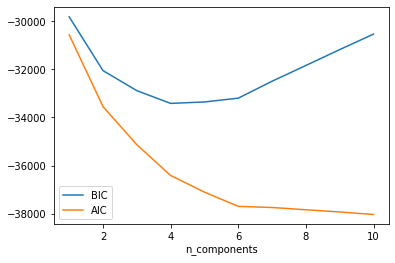

In [85]:
n_components = np.arange(1, 11)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(x_input)
          for n in n_components]

plt.plot(n_components, [m.bic(x_input) for m in models], label='BIC')
plt.plot(n_components, [m.aic(x_input) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

In [86]:
gmm = GaussianMixture(5, covariance_type='full',random_state=0)
gmm.fit(x_input)
y_gmm = kmeans.predict(x_input)

In [87]:
y_gmm

array([2, 0, 0, 1, 0, 0, 2, 3, 4, 2, 2, 3, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       3, 2, 3, 2, 1, 3, 1, 0, 4, 3, 4, 4, 1, 3, 2, 0, 1, 1, 2, 1, 3, 1,
       1, 0, 1, 4, 2, 2, 2, 2, 0, 0, 0, 1, 0, 1, 1, 2, 0, 4, 1, 1, 3, 1,
       4, 1, 3, 1, 1, 3, 1, 1, 2, 2, 2, 0, 1, 2, 0, 4, 0, 2, 1, 0, 2, 2,
       2, 4, 1, 0, 1, 0, 2, 4, 4, 2, 3, 4, 1, 0, 1, 4, 1, 0, 2, 1, 1, 4,
       0, 0, 0, 2, 1, 1, 0, 2, 2, 1, 1, 2, 4, 1, 2, 2, 3, 4, 1, 2, 0, 3,
       2, 4, 2, 2, 1, 2, 4, 4, 3, 4, 3, 2, 4, 1, 2, 3, 1, 1, 4, 2, 1, 0,
       3, 2, 4, 1, 2, 2, 0, 2, 1, 1, 4, 4, 2, 1, 1, 1, 2, 2, 0, 1, 1, 1,
       0, 4, 4, 1, 0, 1, 3, 1, 1, 4, 0, 1, 1, 4, 2, 4, 2, 1, 2, 0, 1, 3,
       3, 1, 0, 4, 1, 2, 1, 4, 2, 1, 4, 4, 4, 1, 4, 2, 4, 0, 0, 3, 1, 1,
       2, 0, 2, 2, 4, 1, 1, 4, 0, 0, 1, 4, 3, 1, 3, 2, 0, 1, 1, 0, 2, 2,
       1, 0, 3, 2, 1, 2, 3, 2, 4, 0, 1, 1, 3, 0, 1, 1, 4, 3, 2, 4, 1, 1,
       0, 2, 2, 0, 2, 3, 3, 2, 2, 2, 1, 0, 0, 0, 2, 2, 4, 4, 2, 0, 3, 2,
       2, 0, 2, 2, 1, 0, 2, 1, 4, 0, 4, 1, 2, 0, 1,

#### Visualize kMeans cluster with T-SNE

In [88]:
import plotly.express as px

fig = px.scatter(embedding_labels, x="tsne_1", y="tsne_2", size_max=60,
                 hover_name="word", color=y_gmm)

fig.update_traces(textposition='top center')

fig.update_layout(
    hoverlabel=dict(
        bgcolor="white", 
        font_size=16, 
        font_family="Rockwell"
    )
)


fig.show()

#### Visualize K-Means cluster with PCA

In [89]:
import plotly.express as px

fig = px.scatter(embedding_labels, x="pca_1", y="pca_2", size_max=60,
                 hover_name="word", color=y_gmm)

fig.update_traces(textposition='top center')

fig.update_layout(
    hoverlabel=dict(
        bgcolor="white", 
        font_size=16, 
        font_family="Rockwell"
    )
)


fig.show()

#### Conclusion GMM

Both GMM and K-Means cluster generated similar types of results.